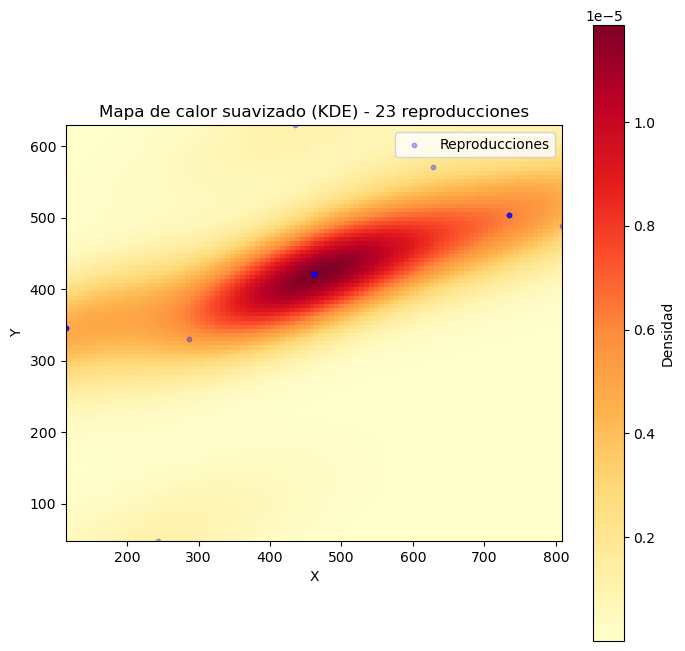

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

# Ruta al archivo CSV generado por GAMA
archivo_csv = "../output/reproducciones/reproduccion.csv"  # ajusta si es necesario

# Crear figura y eje
fig, ax = plt.subplots(figsize=(8, 8))  # Aspecto cuadrado

if os.path.exists(archivo_csv):
    try:
        # Leer el CSV asumiendo que tiene encabezado
        df = pd.read_csv(archivo_csv)

        # Convertir a float y redondear coordenadas si quieres
        df["x"] = df["location_x"].astype(float)
        df["y"] = df["location_y"].astype(float)

        # Extraer arrays de coordenadas
        x = df["x"].values
        y = df["y"].values

        # Verificar si hay suficientes puntos para KDE
        if len(x) < 2:
            print(f"⚠️ Solo hay {len(x)} punto(s). Se necesitan al menos 2 para KDE.")
            if len(x) > 0:
                scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
                ax.set_title(f"Reproducciones ({len(x)} punto{'s' if len(x) != 1 else ''})")
                ax.set_xlabel("X")
                ax.set_ylabel("Y")
                ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
                ax.legend()
        else:
            # Verificar si todos los puntos son idénticos (varianza cero)
            if np.var(x) == 0 and np.var(y) == 0:
                print("⚠️ Todos los puntos están en la misma ubicación. No se puede calcular KDE.")
                scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
                ax.set_title(f"Reproducciones ({len(x)} puntos en misma ubicación)")
                ax.set_xlabel("X")
                ax.set_ylabel("Y")
                ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
                ax.legend()
            else:
                # Verificar si los datos están en una línea (colinealidad)
                # Calcular la correlación para detectar datos casi colineales
                if len(x) >= 3:
                    # Verificar si todos los puntos están en una línea recta
                    # Calcular la varianza perpendicular a la línea principal
                    xy = np.vstack([x, y])
                    cov_matrix = np.cov(xy)
                    eigenvalues = np.linalg.eigvals(cov_matrix)
                    
                    # Si uno de los eigenvalues es muy pequeño comparado con el otro,
                    # los datos están esencialmente en una línea
                    min_eigenval = np.min(eigenvalues)
                    max_eigenval = np.max(eigenvalues)
                    
                    if min_eigenval / max_eigenval < 1e-10 or min_eigenval < 1e-10:
                        print("⚠️ Los datos están en una línea recta o muy cerca. No se puede calcular KDE.")
                        scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
                        ax.set_title(f"Reproducciones ({len(x)} puntos colineales)")
                        ax.set_xlabel("X")
                        ax.set_ylabel("Y")
                        ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
                        ax.legend()
                    else:
                        # Calcular la densidad KDE
                        kde = gaussian_kde(xy)

                        # Definir rango para la cuadrícula (ajusta según tus datos)
                        xmin, xmax = x.min(), x.max()
                        ymin, ymax = y.min(), y.max()
                        
                        # Añadir un pequeño margen si xmin == xmax o ymin == ymax
                        if xmin == xmax:
                            xmin -= 1
                            xmax += 1
                        if ymin == ymax:
                            ymin -= 1
                            ymax += 1

                        # Crear una cuadrícula para evaluar la densidad
                        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
                        positions = np.vstack([xx.ravel(), yy.ravel()])
                        density = np.reshape(kde(positions).T, xx.shape)

                        # Graficar
                        heatmap = ax.imshow(np.rot90(density), cmap='YlOrRd', extent=[xmin, xmax, ymin, ymax])
                        scatter = ax.scatter(x, y, c='blue', s=10, alpha=0.3, label='Reproducciones')
                        ax.set_title(f"Mapa de calor suavizado (KDE) - {len(x)} reproducciones")
                        ax.set_xlabel("X")
                        ax.set_ylabel("Y")
                        ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
                        ax.legend()
                        fig.colorbar(heatmap, ax=ax, label="Densidad")
                else:
                    # Si hay menos de 3 puntos, solo mostrar scatter plot
                    scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
                    ax.set_title(f"Reproducciones ({len(x)} puntos)")
                    ax.set_xlabel("X")
                    ax.set_ylabel("Y")
                    ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
                    ax.legend()

        plt.show()

    except Exception as e:
        print(f"Error leyendo el CSV o generando el mapa: {e}")
        # Fallback: intentar mostrar solo scatter plot si hay datos
        try:
            df = pd.read_csv(archivo_csv)
            if not df.empty:
                df["x"] = df["location_x"].astype(float)
                df["y"] = df["location_y"].astype(float)
                x = df["x"].values
                y = df["y"].values
                if len(x) > 0:
                    scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
                    ax.set_title(f"Reproducciones ({len(x)} puntos)")
                    ax.set_xlabel("X")
                    ax.set_ylabel("Y")
                    ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
                    ax.legend()
                    plt.show()
        except:
            pass
else:
    print("⚠️ No se encontró el archivo CSV.")


In [2]:
import shutil
import tempfile

def leer_csv_copiado(path_origen):
    try:
        # Crear un archivo temporal para copiar
        with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
            tmp_path = tmp_file.name
        # Copiar el archivo original a temporal
        shutil.copy2(path_origen, tmp_path)
        
        # Leer la copia
        df = pd.read_csv(tmp_path)
        
        # Borrar el archivo temporal
        os.remove(tmp_path)
        
        return df
    except Exception as e:
        print(f"Error copiando o leyendo CSV: {e}")
        return None


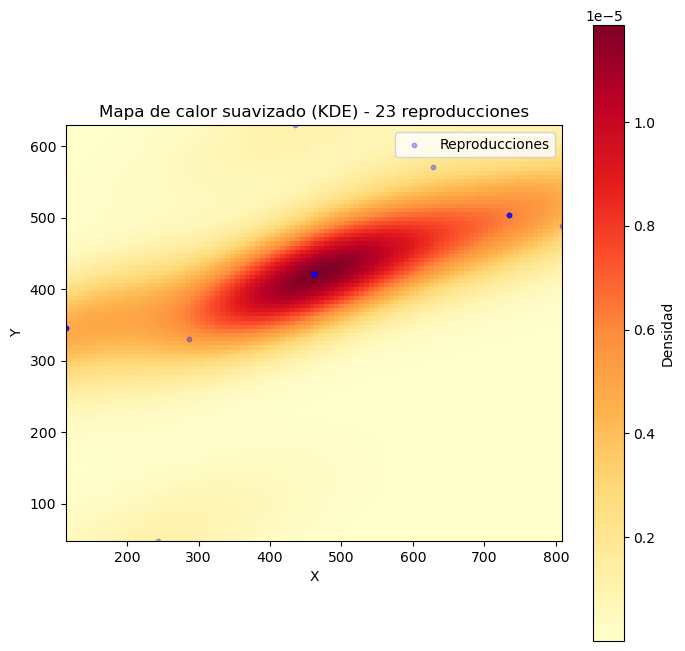

Visualización detenida por el usuario.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
import time

# Configuración
archivo_csv = "../output/reproducciones/reproduccion.csv"  # Ajusta la ruta
auto_update = True         # True para actualizar cada intervalo, False para una ejecución
intervalo_segundos = 1     # Cada cuántos segundos actualizar si auto_update = True
grid_size = 100            # Resolución de la rejilla KDE

def graficar_mapa_calor(ax, path_csv, grid=100):
    if not os.path.exists(path_csv):
        print(f"⚠️ No se encontró el archivo CSV: {path_csv}")
        return

    df = leer_csv_copiado(path_csv)
    if df is None:
        return

    # Convertir coordenadas a float
    df["x"] = df["location_x"].astype(float)
    df["y"] = df["location_y"].astype(float)

    x = df["x"].values
    y = df["y"].values

    if len(x) == 0 or len(y) == 0:
        print("⚠️ No hay datos para graficar.")
        return

    ax.clear()  # Limpia el eje para reemplazar el gráfico viejo
    
    # Verificar si hay suficientes puntos para KDE
    if len(x) < 2:
        # Si hay menos de 2 puntos, solo mostrar scatter plot
        scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
        ax.set_title(f"Reproducciones ({len(x)} punto{'s' if len(x) != 1 else ''})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
        ax.legend()
        print(f"⚠️ Solo hay {len(x)} punto(s). Se necesitan al menos 2 para KDE.")
        return
    
    # Verificar si todos los puntos son idénticos (varianza cero)
    if np.var(x) == 0 and np.var(y) == 0:
        # Todos los puntos están en la misma ubicación
        scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
        ax.set_title(f"Reproducciones ({len(x)} puntos en misma ubicación)")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
        ax.legend()
        print("⚠️ Todos los puntos están en la misma ubicación. No se puede calcular KDE.")
        return

    # Verificar si los datos están en una línea (colinealidad)
    if len(x) >= 3:
        xy = np.vstack([x, y])
        cov_matrix = np.cov(xy)
        eigenvalues = np.linalg.eigvals(cov_matrix)
        
        min_eigenval = np.min(eigenvalues)
        max_eigenval = np.max(eigenvalues)
        
        if min_eigenval / max_eigenval < 1e-10 or min_eigenval < 1e-10:
            print("⚠️ Los datos están en una línea recta o muy cerca. No se puede calcular KDE.")
            scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
            ax.set_title(f"Reproducciones ({len(x)} puntos colineales)")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
            ax.legend()
            return

    try:
        xy = np.vstack([x, y])
        kde = gaussian_kde(xy)

        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
        
        # Añadir un pequeño margen si xmin == xmax o ymin == ymax
        if xmin == xmax:
            xmin -= 1
            xmax += 1
        if ymin == ymax:
            ymin -= 1
            ymax += 1

        xx, yy = np.mgrid[xmin:xmax:grid*1j, ymin:ymax:grid*1j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        density = np.reshape(kde(positions).T, xx.shape)

        heatmap = ax.imshow(np.rot90(density), cmap='YlOrRd', extent=[xmin, xmax, ymin, ymax])
        scatter = ax.scatter(x, y, c='blue', s=10, alpha=0.3, label='Reproducciones')
        ax.set_title(f"Mapa de calor suavizado (KDE) - {len(x)} reproducciones")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
        ax.legend()

        # Manejar barra de color
        if not hasattr(graficar_mapa_calor, "colorbar") or graficar_mapa_calor.colorbar.ax not in ax.figure.axes:
            graficar_mapa_calor.colorbar = ax.figure.colorbar(heatmap, ax=ax, label="Densidad")
        else:
            graficar_mapa_calor.colorbar.update_normal(heatmap)
            
    except Exception as e:
        print(f"Error al calcular KDE: {e}")
        # Fallback: mostrar solo scatter plot
        scatter = ax.scatter(x, y, c='blue', s=50, alpha=0.7, label='Reproducciones')
        ax.set_title(f"Reproducciones ({len(x)} puntos)")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')  # Mantener relación de aspecto 1:1
        ax.legend()
        

# Ejecutar el visualizador con actualización automática
if auto_update:
    plt.ion()  # Modo interactivo
    fig, ax = plt.subplots(figsize=(8, 8))  # Aspecto cuadrado
    
    try:
        while True:
            graficar_mapa_calor(ax, archivo_csv, grid=grid_size)
            plt.pause(0.01)  # Permite actualización y refresco
            time.sleep(intervalo_segundos)
    except KeyboardInterrupt:
        print("Visualización detenida por el usuario.")
        plt.ioff()  # Salir del modo interactivo
else:
    fig, ax = plt.subplots(figsize=(8, 8))  # Aspecto cuadrado
    graficar_mapa_calor(ax, archivo_csv, grid=grid_size)
    plt.show()
